In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
# Separate target and features in train dataset
target = train['Survived']
train = train.drop(columns=['Survived'])

In [4]:
# Feature extraction from name.

# Creating the rank column based from the name.
accepted_ranks = ['Mr', 'Mrs', 'Miss', 'Master', 'Other']
rank_transform = {'Mlle': 'Miss', 'Ms': 'Mrs', 'Mme': 'Mrs'}

train['Rank'] = pd.Categorical(train['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1]).replace(rank_transform), categories=accepted_ranks).fillna('Other')
test['Rank'] = pd.Categorical(test['Name'].apply(lambda x: x.split('.')[0].split(' ')[-1]).replace(rank_transform), categories=accepted_ranks).fillna('Other')

In [5]:
# Drop non exploitable columns
unwanted_columns = ['Cabin', 'PassengerId', 'Name', 'Ticket']

train = train.drop(columns=unwanted_columns)
test = test.drop(columns=unwanted_columns)

In [6]:
# Embarked data imputation:
imputed_embarked_value = train['Embarked'].mode()[0]

train['Embarked'] = train['Embarked'].fillna(imputed_embarked_value)
test['Embarked'] = test['Embarked'].fillna(imputed_embarked_value)

# Age data imputation:
imputed_age_value = train['Age'].mean()

train['Age'] = train['Age'].fillna(imputed_age_value)
test['Age'] = test['Age'].fillna(imputed_age_value)

In [7]:
# Data encoding
numeric_cols = train.select_dtypes(['float', 'int']).columns
categorical_cols = train.select_dtypes(['category', 'object']).columns

# Data encoding:
encoder = OneHotEncoder()

train_encoded_features = encoder.fit_transform(train[categorical_cols])
test_encoded_features = encoder.transform(test[categorical_cols])

train_encoded = pd.concat([
    train.drop(columns=categorical_cols),
    pd.DataFrame(train_encoded_features.toarray(), columns=encoder.get_feature_names_out())
], axis=1) 

test_encoded = pd.concat([
    test.drop(columns=categorical_cols),
    pd.DataFrame(test_encoded_features.toarray(), columns=encoder.get_feature_names_out())
], axis=1)

# Data normalization
scaler = MinMaxScaler()
train_encoded[numeric_cols] = scaler.fit_transform(train_encoded[numeric_cols])
test_encoded[numeric_cols] = scaler.transform(test_encoded[numeric_cols])

In [8]:
# Model exploration:
random_state = 111

In [9]:
# Imports and display results function
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def display_results(y_real, y_pred):
    print(f"Accuracy: {accuracy_score(y_real, y_pred)}")

    print(classification_report(y_real, y_pred))

    cm = confusion_matrix(y_real, y_pred)

    palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=palette);

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Died', 'Survived']) 
    ax.yaxis.set_ticklabels(['Died', 'Survived'])

In [10]:
# Split train dataset in Train and Validation
X_train, X_test, y_train, y_test = train_test_split(train_encoded, target, test_size=0.3, random_state=random_state)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
best_params = {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'tol': 0.001}
Accuracy: 0.8246268656716418
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       171
           1       0.78      0.71      0.75        97

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



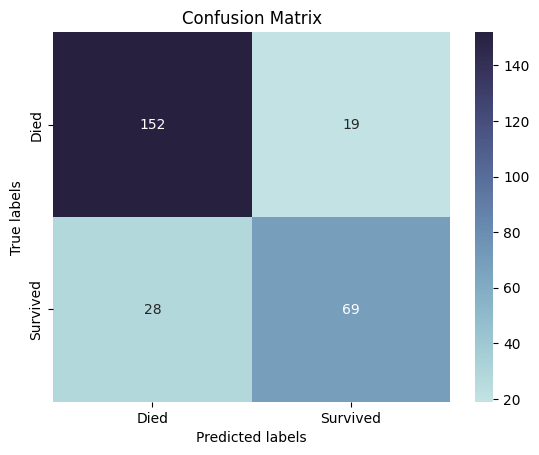

In [28]:
# Grid Search with Logistic Regression

param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 300],
    'tol': [1e-3, 1e-4],
    'random_state': [42]
}

model=LogisticRegression(random_state=random_state)

grid_search=GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'{best_params = }')

y_pred = best_model.predict(X_test)

display_results(y_test, y_pred)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
best_params = {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}
Accuracy: 0.8134328358208955
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       171
           1       0.76      0.70      0.73        97

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268



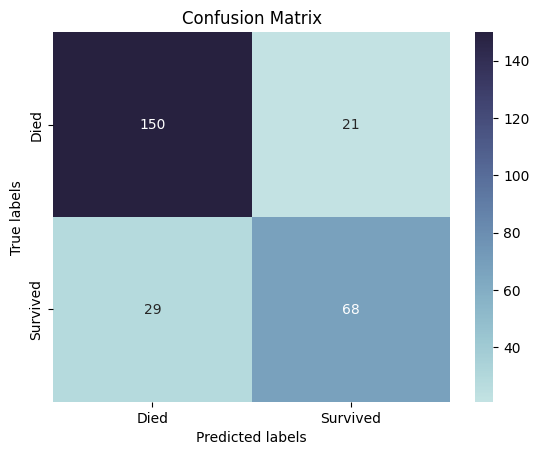

In [31]:
# Grid Search with Logistic Regression

param_grid={
    'max_depth':[3,5,10,None],
    'n_estimators':[10,100,200],
    'max_features':[1,3,5,7],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[1,2,3]
}


model=RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'{best_params = }')

y_pred = best_model.predict(X_test)

display_results(y_test, y_pred)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
best_params = {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1}
Accuracy: 0.8134328358208955
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       171
           1       0.73      0.77      0.75        97

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.82      0.81      0.81       268



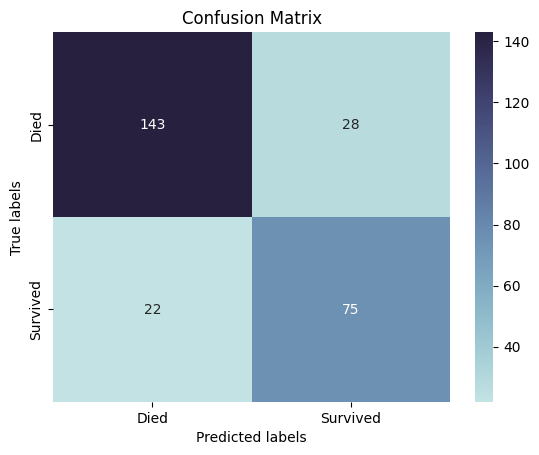

In [33]:
# Grid Search with Logistic Regression

param_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01, 0.001]
}

model = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

grid_search=GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'{best_params = }')

y_pred = best_model.predict(X_test)

display_results(y_test, y_pred)
